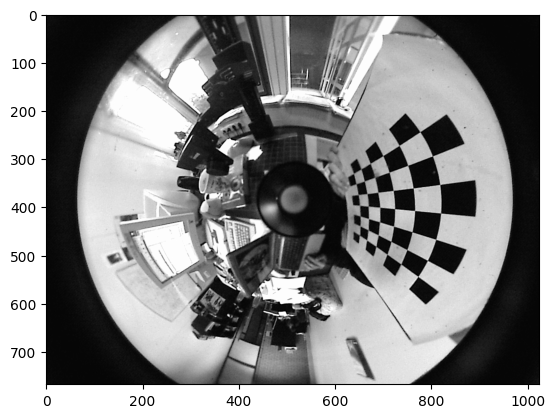

In [436]:
import pathlib
import cv2
from matplotlib import pyplot as plt
import numpy as np

checkboard_size = (7, 4)

def read_images(path):
    path = pathlib.Path(path)
    images = []
    gray_images = []
    for image_path in path.glob('*.jpg'):
        image = cv2.imread(str(image_path))

        images.append(image)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(gray_image)
    return images, gray_images

images, gray_images = read_images('referenceData/OcamCalib')
plt.imshow(gray_images[0], cmap='gray')

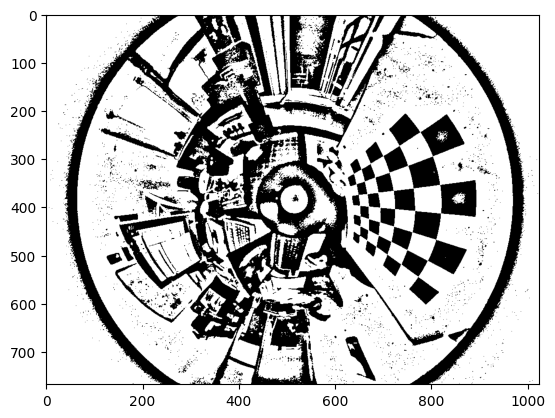

In [437]:
def calculate_adaptive_threshold_kernel_size(img):
    # Calculate the kernel size for adaptive thresholding
    # based on the image size
    height, width = img.shape
    kernel_size = int(height * width / 10000)
    if kernel_size % 2 == 0:
        kernel_size += 1
    return kernel_size

binary_images = []
for image in gray_images:
    # Apply thresholding
    kernel_size = calculate_adaptive_threshold_kernel_size(image)
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, kernel_size, 5)
    binary_images.append(binary)

plt.imshow(binary_images[0], cmap='gray')

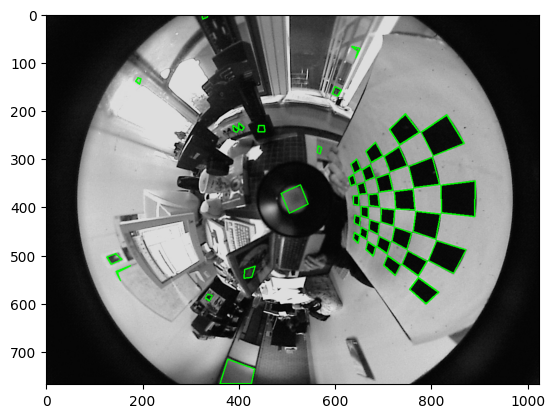

In [438]:
def dilate(img, kernel="rect", iterations=1):
    if kernel == "cross":
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    elif kernel == "rect":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    elif kernel == "ellipse":
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    else:
        raise ValueError("Unknown kernel type")
    return cv2.dilate(img, kernel, iterations=iterations)
    
# TODO: double check this.
def find_quadrangles(img):
    quadrangles = []
    height, width = img.shape
    quadrangle_perimeter_threshold = 2 * (height + width) / 100
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Approximate the contour with a polygon
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.1 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # If the polygon has 4 vertices, it is a quadrangle
        approx_perimeter = cv2.arcLength(approx, True)
        if (approx_perimeter < quadrangle_perimeter_threshold):
            continue
        if len(approx) == 4:
            quadrangles.append(approx)
        # quadrangles.append(approx)
    return quadrangles

def draw_quadrangles(img, quadrangles):
    for quadrangle in quadrangles:
        cv2.drawContours(img, [quadrangle], 0, (0, 255, 0), 2)
    return img

def remove_similar_quadrangles(quadrangles, old_quadrangles, epsilon):
    if (len(old_quadrangles) == 0):
        return quadrangles

    new_quadrangles = []
    for quadrangle in quadrangles:
        is_similar = False
        for old_quadangle in old_quadrangles:
            if is_quadrangles_similar(quadrangle, old_quadangle, epsilon):
                is_similar = True
                break
        if not is_similar:
            new_quadrangles.append(quadrangle)

    return new_quadrangles

def is_quadrangles_similar(quadrangle1, quadrangle2, epsilon):
    # check if they have similar center and similar perimeter
    
    center_1 = get_quadrangle_center(quadrangle1)
    center_2 = get_quadrangle_center(quadrangle2)
    center_distance = np.linalg.norm(center_1 - center_2)

    perimeter_1 = cv2.arcLength(quadrangle1, True)
    perimeter_2 = cv2.arcLength(quadrangle2, True)
    perimeter_distance = np.abs(perimeter_1 - perimeter_2)

    return center_distance < epsilon or perimeter_distance < epsilon

def get_quadrangle_center(quadrangle):
    center = quadrangle.mean(axis=-1).squeeze()
    return center

def find_quadrangles_iteratively(img, max_iterations=1):
    all_quadrangles = []
    similar_quad_epsilon = 3
    num_checkers = checkboard_size[0] * checkboard_size[1]
    for i in range(max_iterations):
        img = dilate(img)
        quadrangles = find_quadrangles(img)
        # increase similar quad espilon for each iteration because dilation shifts the quadrangles. x3 is matched with the dilation kernel size.
        new_quadrangles = remove_similar_quadrangles(quadrangles, all_quadrangles, epsilon=similar_quad_epsilon + (i+1) * 3)
        all_quadrangles += new_quadrangles
    return all_quadrangles


# is_quad_sim = is_quadrangles_similar(np.array([[[1,1]],[[2,2]],[[3,3]],[[5,5]]]), np.array([[[1,1]],[[2,2]],[[3,3]],[[4,4]]]), epsilon=3)
# print(is_quad_sim)
test_image = binary_images[0]
test_original = images[0]
quadrangles = find_quadrangles_iteratively(test_image, max_iterations=3)
test_original = draw_quadrangles(test_original, quadrangles)
plt.imshow(test_original)